In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

### Read the root directory of images and extract pixel features and flatten into a 1d vector

In [3]:
dataset_path = 'Lab2_data' 
features = []
labels = []

# Loop over each subject folder
for subject_folder in sorted(os.listdir(dataset_path)):
    if subject_folder.startswith('s'):
        subject_number = int(subject_folder[1:])  
        subject_path = os.path.join(dataset_path, subject_folder)

        # Loop over each image in the subject folder
        for image_file in sorted(os.listdir(subject_path)):
            if image_file.endswith('.pgm'):
                image_path = os.path.join(subject_path, image_file)
                
                # Load the image
                img = Image.open(image_path)
                img_array = np.array(img)
                
                # Flatten the image to 1D vector
                flattened_vector = img_array.flatten()

                # Append data and label
                features.append(flattened_vector)
                labels.append(subject_number)

features = np.array(features)
labels = np.array(labels)

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)      

Features shape: (400, 10304)
Labels shape: (400,)


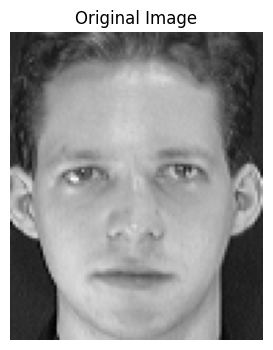

In [4]:
img  = features[0]

original = features[0].reshape(112,92)  # Assuming ORL face dataset shape

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original, cmap='gray')
plt.axis('off')

plt.show()

### Split Data into Odd indexed rows for training and even indexed for testing

In [5]:
X_train = features[::2]
X_test  = features[1::2] 
y_train = labels[::2]
y_test  = labels[1::2]

In [6]:
import numpy as np

class PCA:
    def __init__(self, alpha=0.95):
        self.alpha = alpha
        self.cov_matrix = None
        self.eigen_vals = None
        self.eigen_vecs = None
        self.k = None
        self.top_k_vecs = None
        self.mu = None

    def _calculate_covariance(self, X):
        # Compute mean and center data
        self.mu = np.mean(X, axis=0)
        X_centered = X - self.mu
        # Use unbiased estimator: divide by n-1
        cov = (1.0 / (X_centered.shape[0] - 1)) * (X_centered.T @ X_centered)
        return cov

    def fit(self, X):
        # Fit PCA: compute covariance, eigen decomposition, sort, and save
        self.cov_matrix = self._calculate_covariance(X)
        self.eigen_vals, self.eigen_vecs = np.linalg.eigh(self.cov_matrix)

        # Sort eigenvalues and eigenvectors in descending order
        idx = np.argsort(self.eigen_vals)[::-1]
        self.eigen_vals = self.eigen_vals[idx]
        self.eigen_vecs = self.eigen_vecs[:, idx]

        # Save for later use
        np.save('eigen_vals.npy', self.eigen_vals)
        np.save('eigen_vecs.npy', self.eigen_vecs)
        np.save('mean_vector.npy', self.mu)
        
        self.set_alpha(self.alpha)

    def load_eigen(self):
        # Load precomputed eigenvalues, eigenvectors, and mean
        self.eigen_vals = np.load('eigen_vals.npy')
        self.eigen_vecs = np.load('eigen_vecs.npy')
        self.mu = np.load('mean_vector.npy')

    def set_alpha(self, alpha):
        # Set variance threshold and compute top-k components
        self.alpha = alpha
        cum_var = np.cumsum(self.eigen_vals)
        total = cum_var[-1]
        ratio = cum_var / total
        self.k = np.searchsorted(ratio, self.alpha) + 1
        self.top_k_vecs = self.eigen_vecs[:, :self.k]

    def transform(self, X):
        X_centered = X - self.mu
        return X_centered @ self.top_k_vecs

    def fit_transform(self, X):
        self.fit(X)
        self.set_alpha(self.alpha)
        return self.transform(X)

    def inverse_transform(self, Z):
        self.set_alpha(self.alpha)
        return (Z @ self.top_k_vecs.T) + self.mu


Alpha: 0.8
Number of principal components retained: 44
Reduced feature shape: (400, 44)


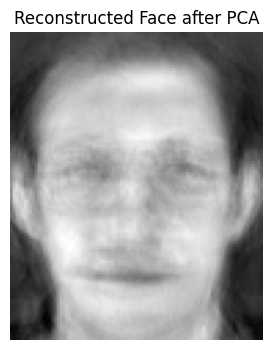

Alpha: 0.85
Number of principal components retained: 68
Reduced feature shape: (400, 68)


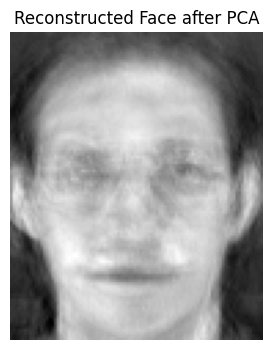

Alpha: 0.9
Number of principal components retained: 111
Reduced feature shape: (400, 111)


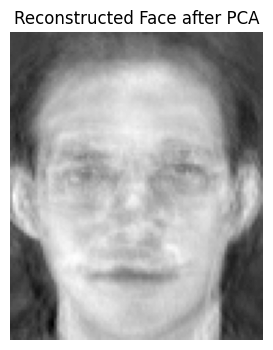

Alpha: 0.95
Number of principal components retained: 190
Reduced feature shape: (400, 190)


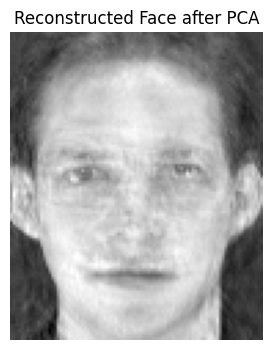

In [7]:
pca = PCA()

pca.load_eigen()

alphas = [0.8, 0.85, 0.9, 0.95]
for alpha in alphas:
    pca.set_alpha(alpha)
    reduced_features = pca.transform(features)

    print(f"Alpha: {alpha}")
    print(f"Number of principal components retained: {pca.k}")
    print(f"Reduced feature shape: {reduced_features.shape}")

    samples = reduced_features[0:1]

    for sample in samples:
        plt.figure(figsize=(8, 4))
        
        reconstructed_sample = pca.inverse_transform(sample)
        
        reconstructed_sample = reconstructed_sample.reshape(112, 92)

        plt.imshow(reconstructed_sample, cmap='gray')
        plt.title("Reconstructed Face after PCA")
        plt.axis('off')
        plt.show()
        
        


## K-means Clustering


In [89]:
import numpy as np
from scipy.stats import mode
from collections import Counter
import matplotlib.pyplot as plt

# --- K-Means Functions (modular) ---
def initialize_centroids(X, K):
    indices = np.random.choice(X.shape[0], K, replace=False)
    return X[indices]



def assign_clusters(X, centroids):
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2) # Compute distances to centroids L2 norm (Euclidean distance)
    clustring =np.argmin(distances, axis=1)
    
    return clustring

def update_centroids(X, labels, K):
    new_centroids = np.zeros((K, X.shape[1]))
    for k in range(K):
        cluster_points = X[labels == k]
        if len(cluster_points) > 0:
            new_centroids[k] = np.mean(cluster_points, axis=0)
    return new_centroids

def kmeans(X, K, max_iters=300, tol=1e-4):
   
    for attempt in range(100):  # Try multiple times to get valid clustering
        centroids = initialize_centroids(X, K)
        for _ in range(max_iters):
            labels = assign_clusters(X, centroids)
            
            # Check if all clusters have at least one sample
            unique_labels = np.unique(labels)
            if len(unique_labels) < K:
                print(" Empty cluster detected. Reinitializing centroids...")
                break  # Restart with new centroids

            new_centroids = update_centroids(X, labels, K)

            if np.allclose(centroids, new_centroids, atol=tol):
                print(f"Attempt {attempt + 1}: K-Means converged with {len(unique_labels)} clusters.")
                return labels, new_centroids  # Converged and valid

            centroids = new_centroids
        

    raise ValueError("K-Means failed to assign all clusters even after multiple attempts.")

# --- Clustering Accuracy Function ---
def calculate_clustering_accuracy(true_labels, cluster_labels, num_classes):
    new_labels = np.zeros_like(cluster_labels)
    for i in range(num_classes):
        mask = cluster_labels == i
        if np.any(mask):
            new_labels[mask] = mode(true_labels[mask])[0]

    accuracy = np.mean(new_labels == true_labels)
    return accuracy



def majority_vote_label_mapping(true_labels, cluster_labels,k):
    """
    Maps each cluster index to the most frequent true label using majority voting.
    Returns the mapped predicted labels and the mapping dictionary.
    """
    mapping = {}
    new_labels = np.zeros_like(cluster_labels)

    for cluster_id in range(k):
        # Find the true labels of samples in this cluster
        indices = np.where(cluster_labels == cluster_id)[0] # Get indices of samples in this cluster
        true_labels_in_cluster = true_labels[indices] # Get true labels of samples in this cluster

        # If no true labels in this cluster, skip
        # This can happen if a cluster is empty it happens in rare cases where In rare cases (especially with bad centroid initialization or too many clusters, e.g., K > actual groups), some clusters may never get assigned any points.
        if len(true_labels_in_cluster) == 0: 
            continue

        # Count the frequency of each true label
        most_common_label = Counter(true_labels_in_cluster).most_common(1)[0][0]

        # Save the mapping
        mapping[cluster_id] = most_common_label

        # Assign the mapped label to all points in the cluster
        new_labels[indices] = most_common_label
        
    return new_labels, mapping


    

In [ ]:
def plot_accuracy_vs_K(results, alphas, Ks):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 6))
    for alpha in alphas:
        accuracies = [results[alpha][K] for K in Ks]
        plt.plot(Ks, accuracies, marker='o', label=f'α = {alpha}')

    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Clustering Accuracy")
    plt.title("Accuracy vs K (for each Alpha)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_accuracy_vs_alpha(results, alphas, Ks):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 6))
    for K in Ks:
        accuracies = [results[alpha][K] for alpha in alphas]
        plt.plot(alphas, accuracies, marker='o', label=f'K = {K}')

    plt.xlabel("Alpha (Variance Retained)")
    plt.ylabel("Clustering Accuracy")
    plt.title("Accuracy vs Alpha (for each K)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



--- K-Means Clustering Results ---


Alpha (α) = 0.80
-----------------------------------
K          Clustering Accuracy
-----------------------------------
Attempt 1: K-Means converged with 20 clusters.
20                      0.4450
Attempt 1: K-Means converged with 40 clusters.
40                      0.6650
Attempt 1: K-Means converged with 60 clusters.
60                      0.8000

Alpha (α) = 0.85
-----------------------------------
K          Clustering Accuracy
-----------------------------------
Attempt 1: K-Means converged with 20 clusters.
20                      0.4350
Attempt 1: K-Means converged with 40 clusters.
40                      0.6400
Attempt 1: K-Means converged with 60 clusters.
60                      0.7900

Alpha (α) = 0.90
-----------------------------------
K          Clustering Accuracy
-----------------------------------
Attempt 1: K-Means converged with 20 clusters.
20                      0.4150
Attempt 1: K-Means converged with 40 clusters.
40     

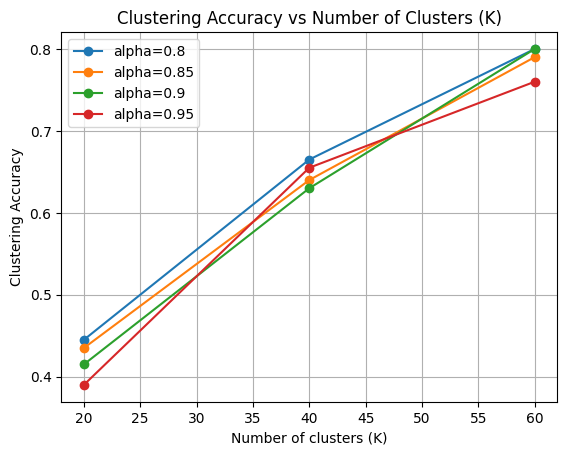

In [ ]:

# --- MAIN PROCESSING AFTER YOUR FEATURE EXTRACTION ---
def Kmeans_Clustering(alphas, Ks):
    pca = PCA()
    pca.load_eigen()
    results = {}
    
    best_acc = -1
    best_model = {
        'alpha': None,
        'K': None,
        'centroids': None,
        'mapping': None,
        'labels': None
    }
    print("\n--- K-Means Clustering Results ---\n")

    for alpha in alphas:
        results[alpha] = {}
        pca.set_alpha(alpha)
        reduced_features = pca.transform(X_train)

        print(f"\nAlpha (α) = {alpha:.2f}")
        print("-" * 35)
        print(f"{'K':<10}{'Clustering Accuracy':>20}")
        print("-" * 35)

        for K in Ks:
            cluster_labels, centroids = kmeans(reduced_features, K)
            mapped_labels, mapping = majority_vote_label_mapping(y_train, cluster_labels, K)
            acc = np.mean(mapped_labels == y_train)
            results[alpha][K] = acc

            print(f"{K:<10}{acc:>20.4f}")
            
            # Update best model if this one is better
            if acc > best_acc:
                best_acc = acc
                best_model['alpha'] = alpha
                best_model['K'] = K
                best_model['centroids'] = centroids
                best_model['mapping'] = mapping
                best_model['labels'] = mapped_labels

    print("\n Clustering completed for all alpha and K values.")
    print(f"\n Best model: α = {best_model['alpha']}, K = {best_model['K']}, Accuracy = {best_acc:.4f}")

    
    return best_model,results
    


alphas = [0.8, 0.85, 0.9, 0.95]
Ks = [20,40,60]
best_model,results = Kmeans_Clustering(alphas, Ks)
plot_accuracy_vs_alpha(results, alphas, Ks)
plot_accuracy_vs_K(results, alphas, Ks)



Small K → not enough clusters → low accuracy.

Medium K (like 40) → good balance → peak accuracy.

Too large K (like 60) → overfitting → accuracy drops.

Lower 
𝛼
α keeps fewer principal components, which may remove noise and redundant information.

Higher 
𝛼
α retains more dimensions, possibly including noise → harder clustering.
When alpha is very high (0.95), PCA keeps more small details (noise), which may confuse clustering.

Keeping less unnecessary detail (like at alpha=0.8) makes clustering easier — the faces are represented in a cleaner, simpler way.

## Evaluation on Test Set (F1 Score, Confusion Matrix, Accuracy)


✅ Evaluation on Test Set:
Accuracy: 0.7300
F1-Score (macro): 0.7032


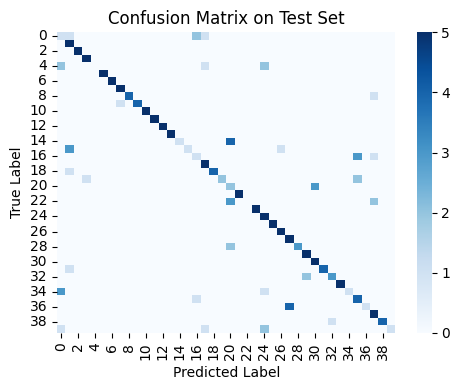

(0.73,
 0.7032207375957376,
 array([[1, 1, 0, ..., 0, 0, 0],
        [0, 5, 0, ..., 0, 0, 0],
        [0, 0, 5, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 5, 0, 0],
        [0, 0, 0, ..., 0, 4, 0],
        [1, 0, 0, ..., 0, 0, 1]], dtype=int64))

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_kmeans_on_test(best_model, X_test, y_test, pca):
    """
    Evaluate the best K-Means model on the test set using Accuracy, F1-Score, and Confusion Matrix.

    Args:
        best_model (dict): Contains centroids, mapping, alpha, and K.
        X_test (np.ndarray): Test set features (before PCA).
        y_test (np.ndarray): Test set true labels.
        pca (object): PCA object with transform method.
    """

    #Apply PCA on X_test
    pca = PCA()
    pca.load_eigen()
    pca.set_alpha(best_model['alpha'])
    X_test_pca = pca.transform(X_test)

    #Predict clusters for test samples using the best model centroids
    centroids = best_model['centroids']
    distances = np.linalg.norm(X_test_pca[:, np.newaxis] - centroids, axis=2)
    test_cluster_labels = np.argmin(distances, axis=1)

    # Map cluster labels to subject IDs
    mapping = best_model['mapping']
    #For each predicted cluster_id in the test set,
    #Retrieve the corresponding subject ID that was assigned by majority vote during training as it is evaltion part
    y_pred = np.array([mapping.get(c, -1) for c in test_cluster_labels])
    
    
    # 4. Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    confusionM = confusion_matrix(y_test, y_pred)

    # 5. Display nicely
    print("\n✅ Evaluation on Test Set:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score (macro): {f1:.4f}")

    plt.figure(figsize=(5, 4))
    sns.heatmap(confusionM, annot=False, cmap="Blues", fmt="d", cbar=True)
    plt.title('Confusion Matrix on Test Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    return acc, f1, confusionM

# Evaluate the best K-Means model on the test set
evaluate_kmeans_on_test(best_model, X_test, y_test, pca)





You have 40 classes (face IDs), indexed from 0 to 39.
The diagonal cells represent correct predictions — darker means more correct.
Off-diagonal cells represent misclassification

The F1-score is a metric that combines:
Precision (How many of the predicted labels are correct)
Recall (How many of the actual labels were correctly predicted

## Bonus: Design an autoencouder NN

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [32]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(10304, 5152),
            nn.ReLU(),
            nn.Linear(5152, 2576),
            nn.ReLU(),
            nn.Linear(2576, 1288),
           
        )
        
        # Decoder 
        self.decoder = nn.Sequential(
         
            nn.Linear(1288, 2576),
            nn.ReLU(),
            nn.Linear(2576, 5152),
            nn.ReLU(),
            nn.Linear(5152, 10304),
            nn.Sigmoid()        
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


In [34]:
def train(lr= 0.0005, epochs = 100,features = None):
    features = features.astype(np.float32) 
    features /= 255.0
    
    # Convert features to a Tensor
    features_tensor = torch.from_numpy(features)
    dataset = TensorDataset(features_tensor)

    # Create DataLoader
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    model = AutoEncoder(input_size=10304)  # Make sure to pass input size if needed
    
    Loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr)
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in dataloader:
            inputs = batch[0].to(device)
            
            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = Loss(outputs, inputs)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")

    return model    

In [ ]:
model = train(epochs = 200,features= features)

Epoch [1/50], Loss: 0.041437
Epoch [2/50], Loss: 0.038112
Epoch [3/50], Loss: 0.029571
Epoch [4/50], Loss: 0.025772
Epoch [5/50], Loss: 0.025055
Epoch [6/50], Loss: 0.024829
Epoch [7/50], Loss: 0.025431
Epoch [8/50], Loss: 0.023714
Epoch [9/50], Loss: 0.024535
Epoch [10/50], Loss: 0.024024
Epoch [11/50], Loss: 0.024275
Epoch [12/50], Loss: 0.024461
Epoch [13/50], Loss: 0.024796
Epoch [14/50], Loss: 0.024784
Epoch [15/50], Loss: 0.023693
Epoch [16/50], Loss: 0.024085
Epoch [17/50], Loss: 0.023839
Epoch [18/50], Loss: 0.023049
Epoch [19/50], Loss: 0.022122
Epoch [20/50], Loss: 0.023375
Epoch [21/50], Loss: 0.022618
Epoch [22/50], Loss: 0.023248
Epoch [23/50], Loss: 0.022831
Epoch [24/50], Loss: 0.022802
Epoch [25/50], Loss: 0.022698
Epoch [26/50], Loss: 0.022372
Epoch [27/50], Loss: 0.022693
Epoch [28/50], Loss: 0.022708
Epoch [29/50], Loss: 0.023546
Epoch [30/50], Loss: 0.023021
Epoch [31/50], Loss: 0.022482
Epoch [32/50], Loss: 0.022877
Epoch [33/50], Loss: 0.022387
Epoch [34/50], Loss

In [28]:
# store pickle file
import pickle
with open('autoencoder_model.pkl', 'wb') as f:
    pickle.dump(model, f)

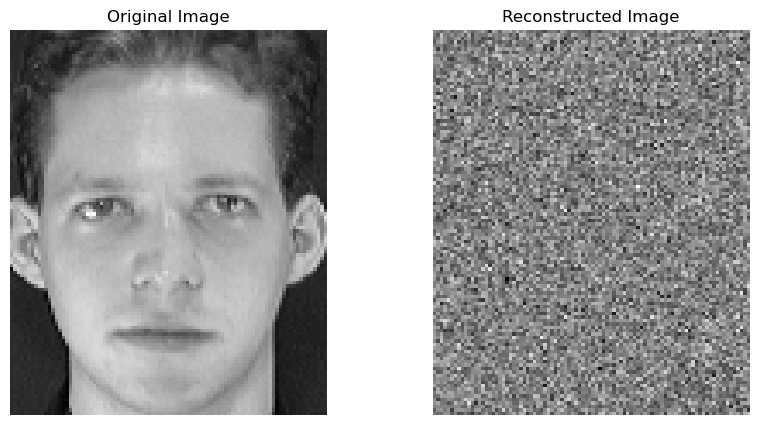

In [ ]:

model = AutoEncoder(input_size=10304).to(device)

sample_idx = 0
sample_image = features[sample_idx]  # shape (10304,)
sample_image_tensor = torch.from_numpy(sample_image).float().to(device)

model.eval()
with torch.no_grad():
    input_tensor = sample_image_tensor.unsqueeze(0)  
    
    reconstructed_tensor = model(input_tensor)  
    
    reconstructed_image = reconstructed_tensor.squeeze(0).cpu().numpy()

original_image = sample_image.reshape(112, 92)
reconstructed_image = reconstructed_image.reshape(112, 92)

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(reconstructed_image, cmap='gray')
plt.axis('off')

plt.show()

